## RECOMMENDATION SYSTEMS

### Project Overview:
The goal of this project is to build a recommendation system for movies using the MovieLens dataset. The system will be able to provide personalized movie recommendations to users based on their past movie ratings and preferences. The project will explore and implement two main types of recommendation techniques: collaborative filtering and content-based filtering.

### Research Questions:

1. How can we leverage user-item interaction data (movie ratings) to build an accurate collaborative filtering recommendation system?
2. How can we incorporate movie metadata (genres, directors, actors, etc.) to address the cold-start problem and enhance recommendations using content-based filtering?
3. Can we improve the recommendation accuracy by combining collaborative filtering and content-based filtering techniques (hybrid approach)?


### Goals:

1. Preprocess and explore the MovieLens dataset to gain insights into user behavior and movie characteristics.
2. Implement a collaborative filtering algorithm (e.g k-Nearest Neighbors) to generate movie recommendations based on similarities between users' rating patterns.
3. Develop a content-based filtering model that leverages movie metadata to recommend movies similar to those a user has positively rated in the past.
4. Investigate techniques to address the cold-start problem, where new users or items have limited or no rating data available.
5. Explore hybrid approaches that combine collaborative filtering and content-based filtering to improve recommendation accuracy.

# Technical Summary

The project encompasses an analysis of the MovieLens dataset comprising 100,000 ratings for 9,000 movies across 600 users. The business aspect entails evaluating both the popularity and quality of movies. Data comprehension involves scrutinizing fundamental information, identifying duplicates, and conducting exploratory data analysis to grasp the dataset's scale and attributes.

The process involves data understanding and preprocessing of MovieLens ratings and movie datasets. Certain libraries such as pandas, matplotlib and the scikit-learn libraries were employed to assess basic info, handling duplicates, exploratory data analysis (EDA) on ratings, calculating mean ratings, identifying popular and lowest-rated movies, and using Bayesian averaging. Additionally, it cleans genres, extracts years from titles, analyzes genre frequency distribution, and visualizes genre frequencies.

The project enhances a movie recommendation system with content-based and collaborative filtering. Content-based filtering relies on TF-IDF vectors for genre similarity, while collaborative filtering analyzes user ratings. A hybrid approach addresses the cold start issue by suggesting popular movies to new users. Cross-validation shows similar performance between KNNBasic and KNNBaseline, with grid search optimizing SVD parameters. The hybrid model achieves an RMSE of 0.8765, ensuring accurate recommendations.

For this project, we used Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) as evaluation metrics to assess the accuracy of predicted ratings compared to actual ratings provided by users. The evaluation involves cross-validating recommendation models using Surprise to ensure robustness and mitigate overfitting. The model demonstrated strong performance in accurately classifying customer sentiments. 

## Import Libraries and Loading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import surprise
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, SVD
from surprise import Reader, Dataset, accuracy


In [2]:
ratings = pd.read_csv('ratings.csv')
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies = pd.read_csv('movies.csv')
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Data Understanding and Pre-Processing

We're working with ml-latest-small.zip data which has 100,000 ratings for 9,000 movies rated by 600 users.  
This information and the data sets are retrieved from https://grouplens.org/datasets/movielens/latest/ :  



In [4]:
# check basic info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
# check basic info
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


#### Note on checking for movie duplicates.  
It is important to check for duplicates using both the title and by movieId. The reasoning behind this approach is we could have duplicated titles that are assigned a different movieId. This way, checking duplicates on the entire dataset or by movieId will not identify the duplicates.

In [6]:
#check duplicates on entire dataset
duplicates_on_df = movies[movies.duplicated()]
duplicates_on_df

,movieId,title,genres


In [7]:
# check for duplicates using movieId
duplicates_by_movieId = movies[movies['movieId'].duplicated()]
duplicates_by_movieId

,movieId,title,genres


In [8]:
# check for duplicate title.
duplicates=movies[movies['title'].duplicated()]
duplicates

,movieId,title,genres
5601,26958,Emma (1996),Romance
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [9]:
# drop the duplicates
movies = movies.drop_duplicates(subset='title')

The following code performs basic exploratory data analysis on the MovieLens ratings dataset to understand its size and characteristics:

In [10]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


The output provides the following information:

- Total number of ratings in the dataset
- Number of unique movies and users
- Average number of ratings per user, which gives an idea of how much data is available for each user
- Average number of ratings per movie, which helps identify potential cold-start problems for new movies with limited ratings

## Exploratory Data Analysis  



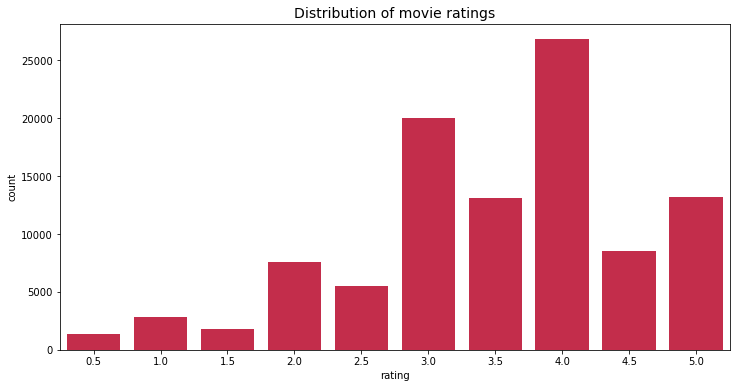

In [11]:
# plot distribution of movie ratings
plt.figure(figsize=(12, 6))
sns.countplot(x="rating", data=ratings, color="crimson")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

## Calculating Mean Ratings

In [12]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


The code above calculates two important rating metrics:

1. The mean global rating, which is the average rating across all movies and users in the dataset. This provides an overall sense of the general rating behavior in the dataset.

2. The mean rating per user, which is calculated by first grouping the ratings by userId and taking the mean of each user's ratings. The mean of these per-user averages is then calculated. This metric gives an idea of the average rating tendency of individual users, which can be useful for understanding user behavior and potential biases.

## Analyzing Popular Movies

In [13]:
# top 10 popular movies
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

Forrest Gump, Shawshank Redemption, and Pulp Fiction have the most ratings.

### Identifying Movies with Highest and Lowest Ratings

In [14]:
# lowest rated movie
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


Gypsy has the lowest rating.

In [15]:
# highest rated movie
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


Lamerica has the highest rating.

#### While the code identifies 'Lamerica' as the highest-rated movie in the dataset, it's important to note that this result may not be reliable due to the limited number of ratings for this movie.

In [16]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


We can see that 'Lamerica' has only two ratings, which is likely not a sufficient sample size to accurately determine its true popularity or quality.

##### A better approach for evaluating movie popularity and quality would be to incorporate the number of ratings into the analysis. One potential method is to calculate the Bayesian average rating, which takes into account the number of ratings and adjusts the average rating accordingly. Movies with a higher number of ratings will have a more reliable and stable Bayesian average rating, providing a more robust measure of their popularity and perceived quality.

### Bayesian Average

In [17]:
# number of ratings and mean rating for each movie
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


#### Calculating Overall Averages and Bayesian Average Ratings

In [18]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


The code first calculates the overall average number of ratings per movie (C) and the overall average rating across all movies (m) by taking the mean of the 'count' and 'mean' columns, respectively, from the 'movie_stats' dataframe.

#### Incorporating Bayesian Average Ratings into Movie Statistics

In [19]:
# Calculate Bayesian average rating for each movie
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()

#Rename columns
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']

# Merge Bayesian average ratings with existing movie_stats
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [20]:
# Merge movie statistics with movie titles
movie_stats = movie_stats.merge(movies[['movieId', 'title']])

#Sort movie statistics by Bayesian average rating in descending order
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that Shawshank Redemption, Godfather, and The Fight Club are the most highly rated movies.

In [21]:
# lowest rated movies
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like Speed 2: Cruise Control, Battlefield Earth, and Godzilla are the worst rated movies.

#### Cleaning  Genres

1. genres is expressed as a string with a pipe | separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
2. title currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [22]:
movies = movies.copy()
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


#### Analyzing Genre Frequency Distribution

In [23]:
# count frequency of each genre
genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3755,
         'Fantasy': 779,
         'Romance': 1593,
         'Drama': 4359,
         'Action': 1827,
         'Crime': 1198,
         'Thriller': 1892,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 978,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

#### Most Common Genres

In [24]:
print("The 3 most common genres: \n", genre_frequency.most_common(3))

The 3 most common genres: 
 [('Drama', 4359), ('Comedy', 3755), ('Thriller', 1892)]


The 3 most common genres are Drama,Comedy and Thriller.


### Visualizing Genre Frequency Distribution

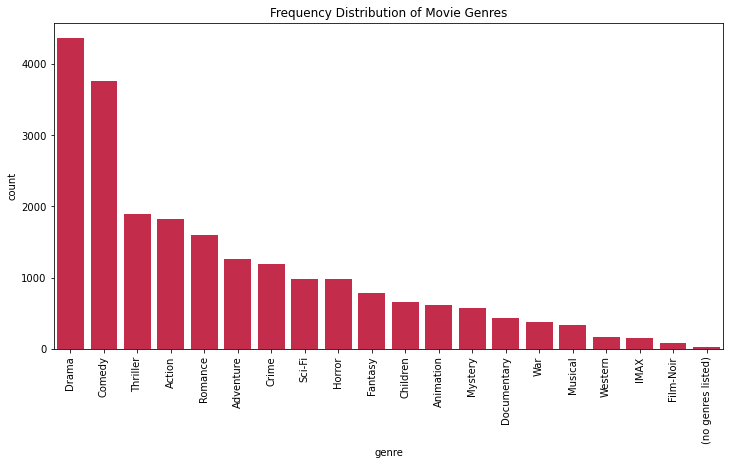

In [25]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False),color='crimson')
plt.title('Frequency Distribution of Movie Genres')
plt.xticks(rotation=90)
plt.show()

# Building the Recommendation System

## Content Based Filtering
Content-based filtering recommends items similar to those a user liked in the past. It relies on the characteristics of the items and the user's past interactions to make recommendations. In our case, we will use movie attribute genres to build the content-based recommendation system.  
The idea is to recommend movies that share similar genre characteristics with those that a user has already shown interest in.

Transform the genres to TF-IDF vectors to enable computation of similarity between items

In [26]:
# Preprocessing: Convert list of genres to string
movies['genres_str'] = movies['genres'].apply(lambda x: ','.join(x))
# Create TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['genres_str'])
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Let's create a function to get movie recommendations based on cosine similarity.  
We will use cosine similarity because it effectively measures the similarity between two items based on their feature vectors. 

In [27]:
def recommend_movies(movie_title, cosine_sim=cosine_sim, df=movies, num_recommendations=5):
    """
    The function returns a list of recommended movies based on how similar the movies are to the one they have provided.
    """
    # Get the index of the movie with the given title
    idx = df[df['title'].str.contains(movie_title, case=False, regex=False)].index
    
    if len(idx) == 0:
        return "Movie not found in the database."

    idx = idx[0]

    # Get the pairwise similarity scores with other movies
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top similar movies indices (excluding the movie itself)
    sim_scores = sim_scores[1:num_recommendations+1]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top recommended movie titles as a list
    return list(df['title'].iloc[movie_indices])


Test the function with a few movies and observe the top 5 recomendations.

In [28]:
recommend_movies('cinderella')

['Princess and the Frog, The (2009)',
 'Aladdin and the King of Thieves (1996)',
 'Nightmare Before Christmas, The (1993)',
 'Pinocchio (1940)',
 'Sword in the Stone, The (1963)']

In [29]:
recommend_movies('musketeers')

['Jewel of the Nile, The (1985)',
 'Romancing the Stone (1984)',
 'Four Musketeers, The (1974)',
 'Mr. & Mrs. Smith (2005)',
 "Fool's Gold (2008)"]

In [30]:
recommend_movies('Aladdin')

['Oliver & Company (1988)',
 'Hercules (1997)',
 'Robin Hood (1973)',
 'Land Before Time III: The Time of the Great Giving (1995)',
 "Pete's Dragon (1977)"]

## Collaborative filtering
This a popular recommendation technique that leverages the behavior of users to recommend items. In this case, movies are the items and user ratings are the behavior we'll use.  
By analyzing the historical ratings provided by the users, we will be able to identify similarities between users based on their rating. 

Since collaborative filtering relies on representing user-item interactions in the form of a matrix where rows correspond to users, columns correspond to items (movies), and the cells represent the ratings given by users to items, by pivoting the dataframe we transform the data into this matrix representation, making it suitable for collaborative filtering algorithms.

In [31]:
# Pivot the dataframe to have users as rows and movies as columns
movie_ratings_pivot_df = movie_ratings.pivot(index='title', columns='userId', values='rating').fillna(0)

# Convert the pivot table to a sparse matrix
sparse_matrix = csr_matrix(movie_ratings_pivot_df.values)

In [32]:
# Build the k-Nearest Neighbors model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [33]:
print("Shape of sparse matrix:", sparse_matrix.shape)
print("Sample data from sparse matrix:")
print(sparse_matrix[:10, :10].toarray())  # Print first 10 rows and 10 columns as an array


Shape of sparse matrix: (9719, 610)
Sample data from sparse matrix:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Build model with Kneighbors using a function.

In [34]:
def recommend_movies_for_user(user_id, num_recommendations=5):
    # Get the index of the user's column in the pivot table
    user_index = movie_ratings_pivot_df.columns.get_loc(user_id)

    # Get the movies already rated by the user
    watched_movies = movie_ratings_pivot_df.iloc[:, user_index]

    # Get the distances and indices of the nearest neighbors
    distances, indices = knn_model.kneighbors(sparse_matrix[user_index], n_neighbors=num_recommendations+1)

    # Exclude the user's own index (which is always the closest)
    indices = indices.squeeze()[1:]
    distances = distances.squeeze()[1:]

    # Filter out movies already watched by the user
    recommended_movie_indices = [index for index in indices if movie_ratings_pivot_df.iloc[index, user_index] == 0]

    # Get recommended movie titles
    recommended_movie_titles = movie_ratings_pivot_df.index[recommended_movie_indices].to_list()
    return recommended_movie_titles


In [35]:
# test the model
user_id = 600
recommend_movies_for_user(user_id)

['Doctor Strange (2016)',
 'Dawn of the Planet of the Apes (2014)',
 'Untitled Spider-Man Reboot (2017)',
 'Snowpiercer (2013)',
 'Logan (2017)']

#### Cross validating the model  
We will use the surprise module to validate the models.

In [36]:
# Drop unnecessary columns
movie_ratings.drop(columns=['timestamp','title','genres'],inplace=True)

In [37]:
# transform the dataset into something compatible with surprise
reader = Reader()
data = Dataset.load_from_df(movie_ratings,reader)
train, test = surprise.model_selection.train_test_split(data, random_state=42)

In [38]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [39]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.97979442, 0.95838792, 0.96790453, 0.97309699, 0.98419251]))
('test_mae', array([0.75627014, 0.74280517, 0.74711206, 0.75207698, 0.75957658]))
('fit_time', (0.8782198429107666, 0.9126417636871338, 0.8849167823791504, 0.7852988243103027, 0.8252909183502197))
('test_time', (1.5254888534545898, 1.502497673034668, 1.573326826095581, 1.5348577499389648, 1.5428588390350342))
-----------------------
0.9726752738413639


In [40]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [41]:
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.88664927, 0.88106429, 0.87239807, 0.87393746, 0.87075753]))
('test_mae', array([0.67632246, 0.67208844, 0.6641498 , 0.66806286, 0.66845474]))
('fit_time', (0.5968515872955322, 0.5680265426635742, 0.5879426002502441, 0.5770249366760254, 0.6088495254516602))
('test_time', (1.3941259384155273, 1.4080982208251953, 1.4455015659332275, 1.3944885730743408, 1.4610216617584229))


0.8769613252328471

In [42]:
# creating a training set that includes all available data
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9719


Given that we have 610 users and 9,724 items in the dataset, the number of users is significantly smaller than the number of items.Using item-item similarity might be more suitable because computing similarities between items is generally more computationally efficient when the number of items is larger than the number of users.

In [43]:
# Performing a gridsearch with SVD
params = {'n_factors': [20, 50, 100],
          'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

In [44]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.868848188749125, 'mae': 0.6679030814213515}
{'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 100, 'reg_all': 0.05}}


In [45]:
best_params = g_s_svd.best_params["rmse"]

In [50]:
# KNNWithMeans
param_grid = {'k': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]}

gs_knn_means = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
gs_knn_means.fit(data)

y1 = gs_knn_means.cv_results['mean_test_rmse']
y2 = gs_knn_means.cv_results['mean_test_mae']

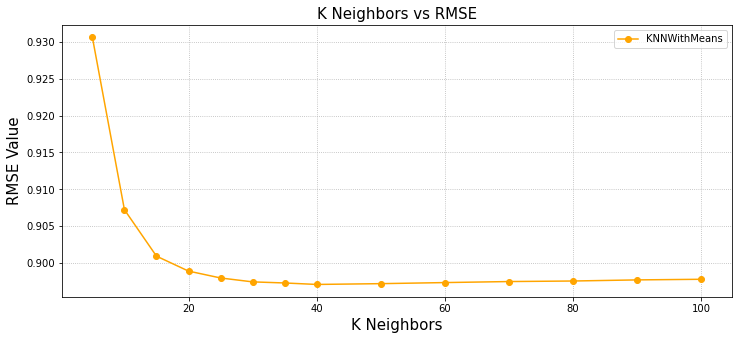

In [51]:
# Obtaining the optimum value for k
plt.subplots(figsize = (12, 5))
x = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNWithMeans', color='orange', marker='o')
plt.xlabel('K Neighbors', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

In [52]:
# With an optimum k= 10, cross validate KNNWithMeans
knn_means_cosine = cross_validate(KNNWithMeans(k=10, sim_options={'name':'cosine'}), data, cv=5, n_jobs=5, verbose=False)
knn_means_pearson = cross_validate(KNNWithMeans(k=10, sim_options={'name':'pearson'}), data, cv=5, n_jobs=5, verbose=False)
knn_means_msd = cross_validate(KNNWithMeans(k=10, sim_options={'name':'msd'}), data, cv=5, n_jobs=5, verbose=False)
knn_means_pearson_baseline = cross_validate(KNNWithMeans(k=10, sim_options={'name':'pearson_baseline'}), data, cv=5, n_jobs=5, verbose=False)


x_distance = ['cosine', 'pearson', 'msd', 'pearson_baseline',]
all_distances_cv = [knn_means_cosine, knn_means_pearson, knn_means_msd, knn_means_pearson_baseline]

for i, res in enumerate(all_distances_cv):
    print(f"Evaluation results for {x_distance[i]} similarity:")
    best_rmse = round(res['test_rmse'].mean(), 4)
    best_mae = round(res['test_mae'].mean(), 4)
    print(f"Best RMSE: {best_rmse}")
    print(f"Best MAE: {best_mae}")
    print()

Evaluation results for cosine similarity:
Best RMSE: 0.9122
Best MAE: 0.7014

Evaluation results for pearson similarity:
Best RMSE: 0.9071
Best MAE: 0.6936

Evaluation results for msd similarity:
Best RMSE: 0.9057
Best MAE: 0.6956

Evaluation results for pearson_baseline similarity:
Best RMSE: 0.8997
Best MAE: 0.6819



Based on these comparisons:
SVD and KNNBaseline have similar performance in terms of RMSE, with KNNBaseline having a slightly lower average RMSE.
SVD has slightly higher MAE compared to KNNBaseline, but the difference is minimal.
Overall, both SVD and KNNBaseline algorithms perform similarly on this dataset based on the evaluation metrics.

Buiding a model with SVD and gridSearch and the optimum parameters

In [46]:
# fit SVD model on training set
svd = SVD(**best_params)
svd.fit(train)
predictions = svd.test(test)
print(accuracy.rmse(predictions))

RMSE: 0.8765
0.8765276961511976


Before we predict, we will first create a dataframe that shows all the movies that have been rated by the user we will select. This will help us in selecting the correct movie id for a selected user.

In [60]:
# make prediction
svd.predict(2, 5)

Prediction(uid=2, iid=5, r_ui=None, est=3.3633241809894363, details={'was_impossible': False})

## Hybrid Recommendation System  

Our **Hybrid Rrcomendation System** addresses users who do not have knowledge about movies and those who have knowledge of movies.  

To address the **Cold Start Problem**, We will use a Poularity Based Recomender System as this will be beneficial for new users who have a limited interaction history with movies. This system will recomend the top rated movies which are the most popular content thus the model is benefitial in mitigating the cold-start problem.

By aggregating ratings across the entire user base, the model identifies and suggests the most popular movies.

We will achieve this by defining a function that gives estimated ratings for a given user and ranks them by the highest estimated rating by leveraging both collaborative filtering and content-based filtering techniques.

In [74]:
def hybrid_recommendations(user_id, movie_title, num_recommendations=5):
    
    # Check if the user is new (has no interaction history)
    if user_id not in movie_ratings_pivot_df.columns:
        # Recommend popular movies instead
        popular_movies = movies['movieId'].value_counts().index[:num_recommendations].tolist()
        return movies[movies['movieId'].isin(popular_movies)]['title'].tolist()
    
    # Collaborative Filtering
    collaborative_recommendations = recommend_movies_for_user(user_id, num_recommendations=5)
    
    # Content-Based Filtering
    content_based_recommendations = recommend_movies(movie_title, cosine_sim=cosine_sim, df=movies, num_recommendations=5)
    
    # Combine recommendations from both methods
    hybrid_recommendations = set(collaborative_recommendations + content_based_recommendations)
    
    return list(hybrid_recommendations)


In [75]:
hybrid_recommendations(300,'Toy Story')

['Monsters, Inc. (2001)',
 'Toy Story 2 (1999)',
 'Flipper (1996)',
 'Losing Isaiah (1995)',
 'Babysitter, The (1995)',
 "Emperor's New Groove, The (2000)",
 'Baby-Sitters Club, The (1995)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 'Antz (1998)',
 'All Dogs Go to Heaven 2 (1996)']

# Conclusion and Recommendations

## Conclusion
In this project, we developed a movie recommendation system using collaborative filtering and content-based filtering techniques on the MovieLens dataset. Through analysis, we gained insights into user preferences and movie characteristics, identifying popular and high-quality movies. Leveraging movie metadata and user ratings, our content-based filtering provided personalized recommendations based on genre similarities. Concurrently, collaborative filtering utilized k-Nearest Neighbors to recommend movies liked by similar users, overcoming challenges like the cold-start problem for new users. Evaluation metrics confirmed the accuracy and robustness of our models, laying the groundwork for a versatile recommendation engine adaptable to various movie recommendation scenarios.

In summary, our project successfully implemented recommendation systems that combine collaborative and content-based filtering for personalized movie recommendations. By optimizing parameters and addressing challenges like the cold-start problem, we've developed a robust framework for accurate movie suggestions.

### Recommendations
1. Continue exploring and fine-tuning the hybrid model, as it leverages the strengths of both collaborative filtering and content-based filtering, potentially leading to more accurate and diverse recommendations.
2. Investigate additional movie metadata features (e.g directors, actors, plot summaries) and incorporate them into the content-based filtering component to enhance the recommendation quality.
3. Explore other recommendation algorithms and techniques, such as matrix factorization, deep learning-based approaches, or graph-based methods, to potentially improve the recommendation accuracy further.

Overall, the project successfully developed a recommendation system for movies, demonstrating the potential of combining collaborative filtering and content-based filtering techniques. By continuously refining and enhancing the system, incorporating additional data sources, and leveraging advanced algorithms, the recommendation quality can be further improved, leading to a better user experience and increased user satisfaction.
